In [89]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
data = pd.read_csv('data/processed_data.csv')
data.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,required_education,industry,function,fraudulent,country_code,city_name,company_profile_tokenized,description_tokenized,requirements_tokenized,benefits_tokenized
0,1,Marketing Intern,Marketing,unknown,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,...,unknown,unknown,Marketing,0,US,New York,"['We', 'Food52', 'created', 'groundbreaking', ...","['Food52', 'fast', 'growing', 'James', 'Beard'...","['Experience', 'content', 'management', 'syste...",[]
1,2,Customer Service - Cloud Video Production,Success,unknown,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland,"['90', 'Seconds', 'worlds', 'Cloud', 'Video', ...","['Organised', 'Focused', 'Vibrant', 'Awesome',...","['What', 'expect', 'Your', 'key', 'responsibil...","['What', 'get', 'usThrough', 'part', '90', 'Se..."
2,3,Commissioning Machinery Assistant (CMA),unknown,unknown,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,...,unknown,unknown,unknown,0,US,Wever,"['Valor', 'Services', 'provides', 'Workforce',...","['Our', 'client', 'located', 'Houston', 'activ...","['Implement', 'pre', 'commissioning', 'commiss...",[]
3,4,Account Executive - Washington DC,Sales,unknown,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,...,Bachelor's Degree,Computer Software,Sales,0,US,Washington,"['Our', 'passion', 'improving', 'quality', 'li...","['THE', 'COMPANY', 'ESRI', 'Environmental', 'S...","['EDUCATION', 'Bachelor', 'Master', 'GIS', 'bu...","['Our', 'culture', 'anything', 'corporate', 'c..."
4,5,Bill Review Manager,unknown,unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,...,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,"['SpotSource', 'Solutions', 'LLC', 'Global', '...","['JOB', 'TITLE', 'Itemization', 'Review', 'Man...","['QUALIFICATIONS', 'RN', 'license', 'State', '...","['Full', 'Benefits', 'Offered']"


### For EDA, we replaced the null values with 'unknown'. We need to remove features which have large number of 'unknown' values as they will not help our model

In [4]:
data.columns

Index(['job_id', 'title', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country_code', 'city_name', 'company_profile_tokenized',
       'description_tokenized', 'requirements_tokenized',
       'benefits_tokenized'],
      dtype='object')

In [5]:
drop_cols = ['job_id', 'department', 'salary_range', 'company_profile_tokenized', 'description_tokenized',
            'requirements_tokenized', 'benefits_tokenized']

In [6]:
#dropping columns not required
data.drop(drop_cols, axis=1, inplace=True)

In [7]:
data['title'] = data['title'].replace({'unknown': 'title_unknown'})
data['employment_type'] = data['employment_type'].replace({'unknown': 'employment_type_unknown'})
data['required_experience'] = data['required_experience'].replace({'unknown': 'required_experience_unknown'})
data['required_education'] = data['required_education'].replace({'unknown': 'required_education_unknown'})
data['function'] = data['function'].replace({'unknown': 'function_unknown'})
data['country_code'] = data['country_code'].replace({'unknown': 'country_code_unknown'})
data['city_name'] = data['city_name'].replace({'unknown': 'city_name_unknown'})
data['industry'] = data['industry'].replace({'unknown': 'industry_unknown'})

In [8]:
data.head()

,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country_code,city_name
0,Marketing Intern,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,0,Other,Internship,required_education_unknown,industry_unknown,Marketing,0,US,New York
1,Customer Service - Cloud Video Production,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,required_education_unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,0,employment_type_unknown,required_experience_unknown,required_education_unknown,industry_unknown,function_unknown,0,US,Wever
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Washington
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth


In [9]:
#replacing 'unknown' in textual columns with blank space as we have to build vectors
data['company_profile'] = data['company_profile'].replace({'unknown': ''})
data['description'] = data['description'].replace({'unknown': ''})
data['requirements'] = data['requirements'].replace({'unknown': ''})
data['benefits'] = data['benefits'].replace({'unknown': ''})

In [10]:
data.columns

Index(['title', 'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country_code', 'city_name'],
      dtype='object')

In [11]:
categorical_cols = ['title', 'employment_type', 'required_experience', 'required_education', 
                    'industry', 'function', 'country_code', 'city_name']

In [12]:
encoded_data = pd.DataFrame()
for col in categorical_cols:
    col_dummies = pd.get_dummies(data[col])
    encoded_data = pd.concat([encoded_data, col_dummies], axis=1)
    data.drop(col, axis=1, inplace=True)

In [13]:
encoded_data.head()

,Electrician,Environmental Technician I,Piping Material Engineer,"Discipline Manager Civil, Structural, Marine, Architectural",FEA Senior engineer,Manager of Project Management Organization - Engineering,Mechanical Engineering Manager,"Resources Change Management, Process Excellence and Change Enablement Manager",ServiceNow Consultant,AUTOCAD OPERATOR,...,wilmington,woodbridge,woodruff,worcester,İstanbul,Αthens,Αθήνα,ΕΛΛΗΝΙΚΟ,마포구 동교동,city_name_unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
encoded_data.shape

(17880, 13854)

In [15]:
tfidf_vectorizer = TfidfVectorizer()

In [16]:
company_profile_vector = tfidf_vectorizer.fit_transform(data['company_profile'])
benefits_vector = tfidf_vectorizer.fit_transform(data['benefits'])
description_vector = tfidf_vectorizer.fit_transform(data['description'])
requirements_vector = tfidf_vectorizer.fit_transform(data['requirements'])

In [17]:
data.shape

(17880, 8)

In [18]:
company_profile_vector

<17880x14824 sparse matrix of type '<class 'numpy.float64'>'
	with 1141404 stored elements in Compressed Sparse Row format>

In [19]:
benefits_vector

<17880x16437 sparse matrix of type '<class 'numpy.float64'>'
	with 423230 stored elements in Compressed Sparse Row format>

In [20]:
vector_combined = hstack([company_profile_vector,benefits_vector, description_vector, requirements_vector, encoded_data])

In [40]:
vector_combined

<17880x153928 sparse matrix of type '<class 'numpy.float64'>'
	with 4684161 stored elements in COOrdinate format>

In [41]:
X_train, X_test, y_train, y_test = train_test_split(vector_combined, data['fraudulent'], test_size=0.30, random_state=42)

In [42]:
X_train.shape

(12516, 153928)

In [43]:
X_test.shape

(5364, 153928)

In [25]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
y_pred = lr_model.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.9800521998508576

### We are getting 98% accuracy using a basic logistic regression model. But accuracy is not a good metric here, as we need high accuracy in only classifying the fake job openings. This means that a real job posting identified as a fake one is ok, but a fake job posting should not be identified as a real one.

In [28]:
y_test.value_counts()

0    5095
1     269
Name: fraudulent, dtype: int64

### Scikit learn sorts labels in ascending order, thus 0's are first column/row and 1's are the second one

In [29]:
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[5090,    5],
       [ 102,  167]], dtype=int64)

### In our test data, there are 5095 real job postings and 269 fake job postings. This can be seen in our confusion matrix where the first row consists of real job openings and the second row the fake ones

### Out of 5095 real job postings, 5090 were correctly predicted and 5 were predicted as fake (good)

### Out of 269 fake job postings,  only 167 were correctly predicted (bad)

### In other words, we have a low recall of 167/(167+102) = 0.62

### Our model's precision is 167/(167+5) = 0.97

In [83]:
def plot_roc_curve(model, X_test, y_test, method):
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]

    ns_probs = [0 for _ in range(len(y_test))]

    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(method+': ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.figure(figsize=(12,8))
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=method)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.981


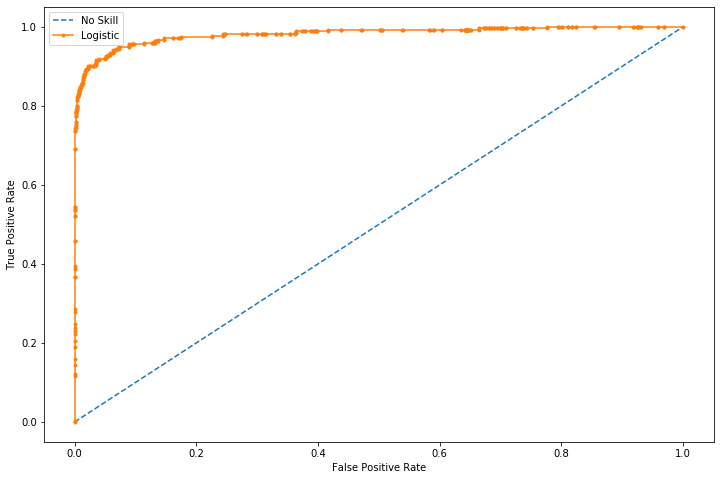

In [85]:
plot_roc_curve(lr_model, X_test, y_test, 'Logistic')

In [30]:
data['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

### We can see there is a class imbalance as there are only 866 fake job postings. We can upsample the fake job openings to check if it improves our model's recall

In [44]:
vector_combined

<17880x153928 sparse matrix of type '<class 'numpy.float64'>'
	with 4684161 stored elements in COOrdinate format>

In [45]:
X_train

<12516x153928 sparse matrix of type '<class 'numpy.float64'>'
	with 3280320 stored elements in Compressed Sparse Row format>

In [48]:
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(X_train, y_train)

In [55]:
X_ROS.shape

(23838, 153928)

In [57]:
y_ROS.shape

(23838,)

In [56]:
y_ROS.value_counts()

1    11919
0    11919
Name: fraudulent, dtype: int64

In [58]:
lr_model = LogisticRegression()
lr_model.fit(X_ROS, y_ROS)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
y_pred = lr_model.predict(X_test)

In [60]:
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[5040,   55],
       [  39,  230]], dtype=int64)

### After using random oversampling of the minority class:

### Out of the 5095 real job postings, 5040 are correctly predicted (as compared to 5090 earlier)

### Out of 269 fake job postings, 230 are correctly predicted (as compared to 167 earlier)

### Our model's recall has improved to 0.86 from 0.62

### As there is a tradeoff between precision and recall, precision dropped to 0.78

In [68]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_ROS, y_ROS)
rf_pred = rf.predict(X_test)
confusion_matrix(y_test, rf_pred, labels=[0,1])

array([[4067, 1028],
       [  23,  246]], dtype=int64)

No Skill: ROC AUC=0.500
Rand. Forest: ROC AUC=0.939


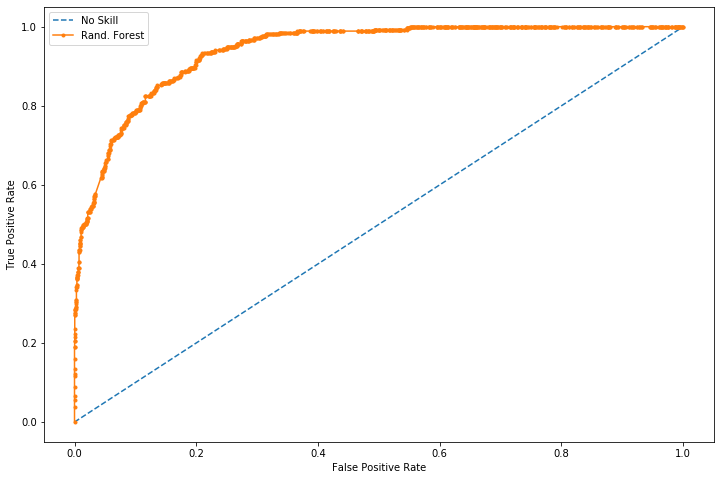

In [87]:
plot_roc_curve(rf, X_test, y_test, 'Rand. Forest')

In [90]:
xgb = XGBClassifier()
optimization_dict = {'max_depth': [2,3,4,5,6,7],
                     'n_estimators': [50,60,70,80,90,100,150,200]}

model = GridSearchCV(xgb, optimization_dict, 
                     scoring='f1_micro', verbose=1)

model.fit(X_train, y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [63]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(X_train, y_train)

In [66]:
lr_model = LogisticRegression()
lr_model.fit(X_SMOTE, y_SMOTE)
y_pred = lr_model.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[5042,   53],
       [  41,  228]], dtype=int64)